In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41155,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:43435,Total threads: 8
Dashboard: http://127.0.0.1:37097/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:40625,


In [2]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import xarray as xr
from xmitgcm import open_mdsdataset
import numpy as np
import warnings
# warnings.filterwarnings("ignore")

data_dir = '/data/SO3/edavenport/tpose6/sep2012/sens_EUC/sens_EUC_75to200m/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(0,itPerFile*num_diags,itPerFile) # adjoint sensitivity will start at 0 and go to 1 lag (1 interval less than total number of timesteps)

# when prefix is not set, this will read all available files 
# have to ignore unkown vars until we have an available_diagnostics.log that includes ADJrhoinsitu
tpose_ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,ref_date='2012-09-01',delta_t=1200,ignore_unknown_vars=True)
tpose_ds['XC'] = tpose_ds.XC.astype(float)
tpose_ds['YC'] = tpose_ds.YC.astype(float)
tpose_ds['Z'] = tpose_ds.Z.astype(float)
tpose_ds['XG'] = tpose_ds.XG.astype(float)
tpose_ds['YG'] = tpose_ds.YG.astype(float)


In [3]:
print(tpose_ds.ADJetan)

<xarray.DataArray 'ADJetan' (time: 122, YC: 336, XC: 1128)> Size: 185MB
dask.array<concatenate, shape=(122, 336, 1128), dtype=float32, chunksize=(1, 336, 1128), chunktype=numpy.ndarray>
Coordinates:
    iter     (time) int64 976B dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 976B 2012-09-01 2012-09-02 ... 2012-12-31
  * XC       (XC) float64 9kB 104.1 104.2 104.4 104.6 ... 291.6 291.8 291.9
  * YC       (YC) float64 3kB -25.92 -25.75 -25.58 -25.42 ... 29.58 29.75 29.92
    rA       (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    Depth    (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    dxF      (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    dyF      (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
Attributes:
    standard_name:  ADJetan
    long_name:      dJ/dEtaN: Sensitivity to sea surface height anomaly
    units:          dJ/m


In [7]:
spectrum = np.abs(np.fft.fft2(tpose_ds.ADJetan, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_etan = tpose_ds.ADJetan.copy(deep=True)
spectrum_etan.values = spectrum
spectrum_etan_avg = spectrum_etan.mean(dim='YC')

spectrum = np.abs(np.fft.fft2(tpose_ds.ADJtaux, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_taux = tpose_ds.ADJtaux.copy(deep=True)
spectrum_taux.values = spectrum
spectrum_taux_avg = spectrum_taux.mean(dim='YC')

spectrum = np.abs(np.fft.fft2(tpose_ds.ADJqnet, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_qnet = tpose_ds.ADJqnet.copy(deep=True)
spectrum_qnet.values = spectrum
spectrum_qnet_avg = spectrum_qnet.mean(dim='YC')

nt = tpose_ds.sizes['time']
nx = tpose_ds.sizes['XC']

dt = 1  # time step
dx = float(tpose_ds['XC'].diff('XC').mean()) * 111.32       # spatial step, a more exact version would be 111.320 * cos(latitude) 

freqs = np.fft.fftfreq(nt, dt)  # cycles per unit time
wavenums = np.fft.fftfreq(nx, dx)  # cycles per unit distance

In [8]:
freqs = 1/(np.fft.fftshift(freqs))
wavenums = 1/(np.fft.fftshift(wavenums))
freqs[len(freqs)//2] = 0 # fix the inf value at the Nyquist frequency
wavenums[len(wavenums)//2] = 0
W, F = np.meshgrid(wavenums, freqs)  # W = wavenumber grid, F = frequency grids
pos_freq_idx = freqs > 0
pos_wavenum_idx = wavenums > 0
W_pos, F_pos = np.meshgrid(wavenums[pos_wavenum_idx], freqs[pos_freq_idx])

spectrum_etan_avg = np.fft.fftshift(spectrum_etan_avg, axes=(0, 1))  # shift freq and wavenumber dims
spectrum_taux_avg = np.fft.fftshift(spectrum_taux_avg, axes=(0, 1))  # shift freq and wavenumber dims
spectrum_qnet_avg = np.fft.fftshift(spectrum_qnet_avg, axes=(0, 1))  # shift freq and wavenumber dims

spec_etan_pos = spectrum_etan_avg[pos_freq_idx, :][:, pos_wavenum_idx]
spec_taux_pos = spectrum_taux_avg[pos_freq_idx, :][:, pos_wavenum_idx]
spec_qnet_pos = spectrum_qnet_avg[pos_freq_idx, :][:, pos_wavenum_idx]

/tmp/ipykernel_1131573/2532880261.py:1: RuntimeWarning: divide by zero encountered in divide
  freqs = 1/(np.fft.fftshift(freqs))
/tmp/ipykernel_1131573/2532880261.py:2: RuntimeWarning: divide by zero encountered in divide
  wavenums = 1/(np.fft.fftshift(wavenums))


In [9]:
# Constants
c = 2.8  # m/s, Kelvin wave speed
beta = 2.28e-11  # 1/m/s, equatorial beta
Lr = np.sqrt(c / beta)  # Rossby radius (m)

# Define wavelength in km
lambda_km = np.logspace(1, 4, 500)  # 10 km to 10,000 km
lambda_m = lambda_km * 1000  # convert to meters

# --- Kelvin wave ---
T_kelvin_days = (2 * np.pi * lambda_m) / (c * 86400)

# --- Rossby wave ---
k_m = 2 * np.pi / lambda_m  # zonal wavenumber in rad/m
omega_rossby = - (beta * k_m) / (k_m**2 + (1 / Lr)**2)  # rad/s
T_rossby_days = (2 * np.pi) / np.abs(omega_rossby) / 86400  # rad/seconds -> days/cycle

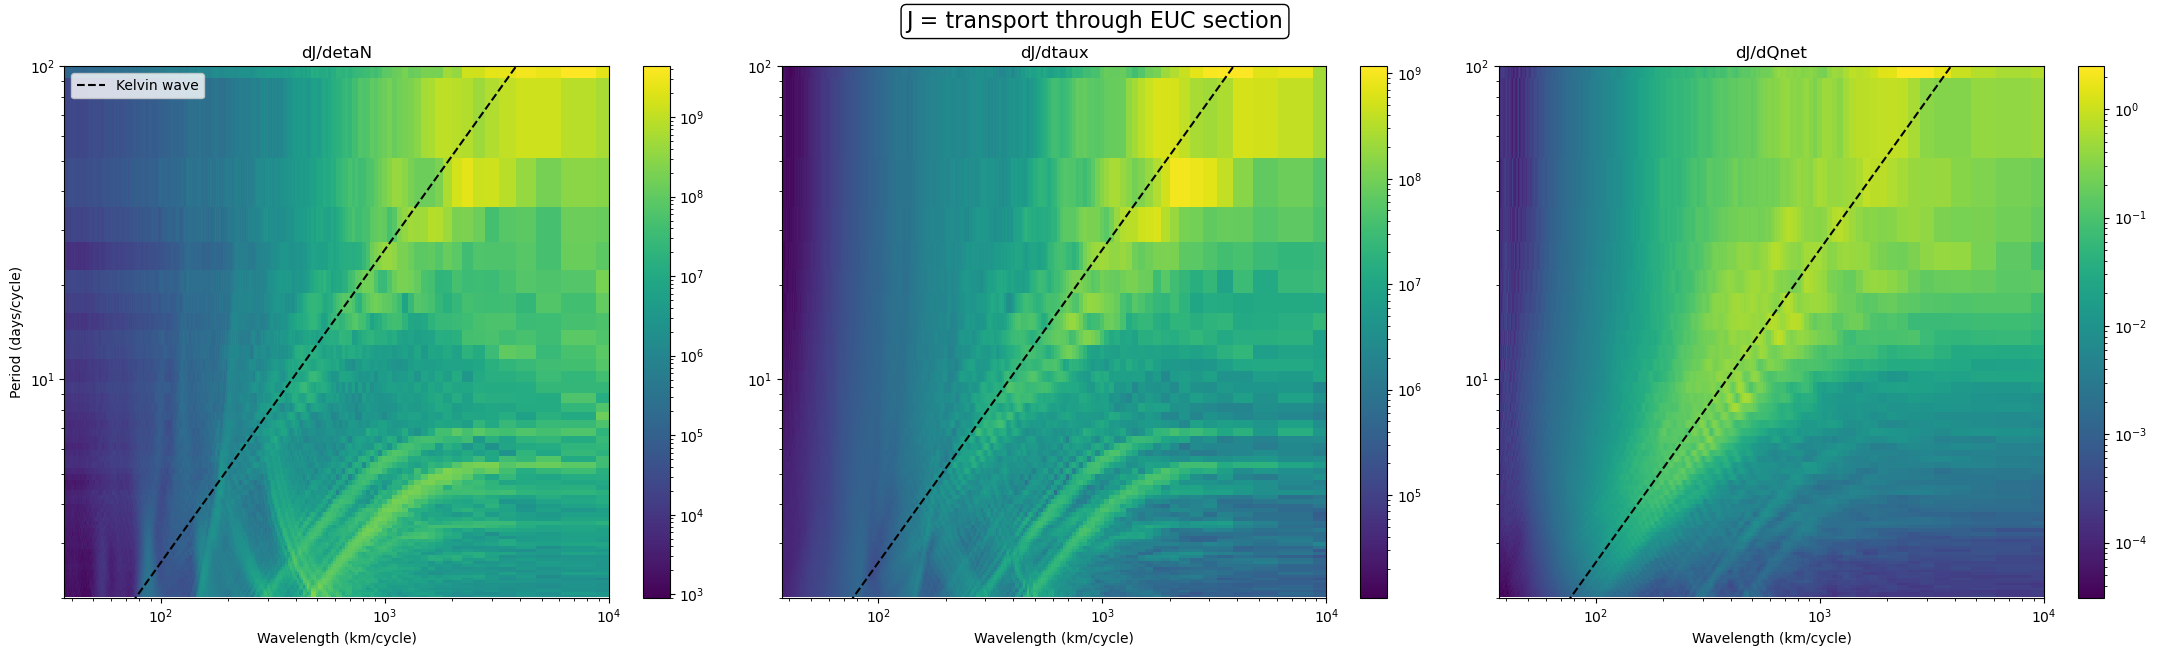

In [22]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(22, 7),ncols=3)
pcm = ax[0].pcolormesh(W_pos, F_pos, spec_etan_pos, shading='auto', cmap='viridis', norm=LogNorm())
ax[0].plot(lambda_km, T_kelvin_days, label='Kelvin wave', color='black', linestyle='--',linewidth=1.5)
ax[0].loglog()
ax[0].legend()
ax[0].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[0].set_ylim(2, 100)  # Frequency in days/cycle
ax[0].set_xlabel('Wavelength (km/cycle)')
ax[0].set_ylabel('Period (days/cycle)')
fig.colorbar(pcm, ax=ax[0])
ax[0].set_title('dJ/detaN')

pcm = ax[1].pcolormesh(W_pos, F_pos, spec_taux_pos, shading='auto', cmap='viridis', norm=LogNorm())
ax[1].plot(lambda_km, T_kelvin_days, label='Kelvin wave (c = 2.8 m/s)', color='black', linestyle='--',linewidth=1.5)
ax[1].loglog()
ax[1].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[1].set_ylim(2, 100)  # Frequency in days/cycle
ax[1].set_xlabel('Wavelength (km/cycle)')
# ax[1].set_ylabel('Period (days/cycle)')
fig.colorbar(pcm, ax=ax[1])
ax[1].set_title('dJ/dtaux')

pcm = ax[2].pcolormesh(W_pos, F_pos, spec_qnet_pos, shading='auto', cmap='viridis', norm=LogNorm())
ax[2].plot(lambda_km, T_kelvin_days, label='Kelvin wave (c = 2.8 m/s)', color='black', linestyle='--',linewidth=1.5)
ax[2].loglog()
ax[2].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[2].set_ylim(2, 100)  # Frequency in days/cycle
ax[2].set_xlabel('Wavelength (km/cycle)')
# ax[2].set_ylabel('Period (days/cycle)')
fig.colorbar(pcm,ax=ax[2])
ax[2].set_title('dJ/dQnet')

# Add text box above the subplots
fig.text(0.5, 0.93, "J = transport through EUC section", ha='center', va='top',
         fontsize=16, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space at the top
plt.show()

In [21]:
print(tpose_ds.data_vars)

Data variables:
    ADJprecip   (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJqnet     (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJrunoff   (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJswdown   (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJtheta    (time, Z, YC, XC) float32 12GB dask.array<chunksize=(1, 66, 336, 1128), meta=np.ndarray>
    ADJvwind    (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJtaux     (time, YC, XG) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJempr     (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJhflux    (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=np.ndarray>
    ADJetan     (time, YC, XC) float32 185MB dask.array<chunksize=(1, 336, 1128), meta=